In [1]:
import sys
import os
import numpy as np
RT_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src"
BA_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/basic_application/src"
sys.path.append(RT_LIBS_PATH)
sys.path.append(BA_LIBS_PATH)

In [2]:
# DS frameworks
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

%matplotlib notebook

In [3]:
# RT packages
from rl import DQNAgent
from env import TradeEnv

from core_v2 import Constructor, Player
from core_v2.data_point import DataPointFactory
from core_v2.observation_builder.precompute import PrecomputeOrderbookDiffFeature

from train_tools import TrainManager, TrainPlot4
from train_tools import plot_and_go, distribution_analysis, get_max_step_factor

2023-09-24 22:21:44.448979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def add_bar_data(x, values, ax=None, name=""):
    ax2 = ax.twinx()
    mask = values>=0
    pos = values * mask
    mask = values<0
    neg = values * mask

    ax2.bar(x , pos, alpha=0.3, color='green', label=name)
    ax2.bar(x , neg, alpha=0.3, color='red', label=name)
    ax2.legend()

# Загрузка датасета

In [6]:
orderbook_levels = [0.0005, 0.001, 0.0025, 0.005, 0.01]

<IPython.core.display.Javascript object>


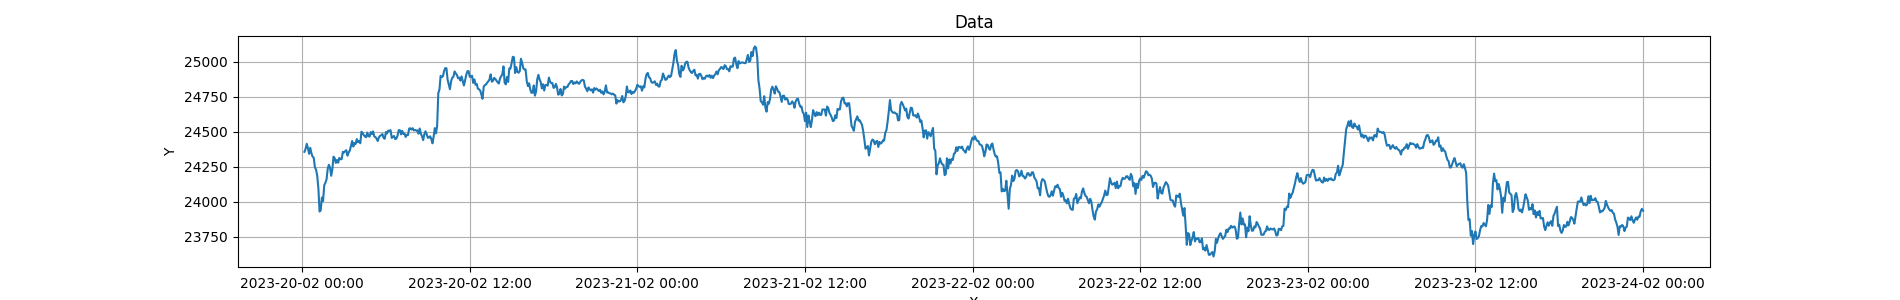

(1151, 11)


In [16]:
#path = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/14.BTC_USDT-60.csv"
path = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/06.BTC_USDT-300.csv"

dataset = pd.read_csv(path, index_col='ts')

#dataset = dataset.iloc[:, :]  # fast test
#data_1 = data_1.iloc[650:1450, :]  # fast train
plot_and_go(dataset, title="Data", fig_x=19, fig_y=3, dpi=50)

precompute = PrecomputeOrderbookDiffFeature()
for level in orderbook_levels:
    dataset = precompute.process(dataset, level)
    name = "diff_" + str(level)
    
    dataset[name] = dataset["bids_" + str(level)] - dataset["asks_" + str(level)]
    

In [8]:
dataset.head()

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,...,diff_0.001,asks_0.0025,bids_0.0025,diff_0.0025,asks_0.005,bids_0.005,diff_0.005,asks_0.01,bids_0.01,diff_0.01
ts,,,,,,,,,,,,,,,,,,,,,
1674691799,2023-01-26 03:09:59,23133.291,23121.400,"{'23133.29': 1.108692, '23133.30': 0.205, '231...","{'23121.40': 0.015445, '23121.39': 0.059584, '...",0.180787,0.087755,0.268542,17,20,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1674692099,2023-01-26 03:14:59,23107.590,23096.870,"{'23107.59': 1.093986, '23107.60': 0.205, '231...","{'23096.87': 0.030187, '23096.86': 0.001283, '...",0.085449,0.054014,0.139463,16,16,...,-5.882594,8.452694,1.171802,-7.280892,12.632520,5.348958,-7.283562,13.476680,8.467567,-5.009113
1674692399,2023-01-26 03:19:59,23092.379,23090.500,"{'23092.38': 1.092843, '23092.39': 0.002146, '...","{'23090.50': 0.036408, '23090.00': 4.5e-05, '2...",0.089454,0.065574,0.155028,34,26,...,-4.379072,5.192870,1.549021,-3.643849,9.929131,5.294177,-4.634954,12.856491,9.262864,-3.593627
1674692699,2023-01-26 03:24:59,23093.000,23090.500,"{'23093.00': 0.205, '23096.18': 0.432972, '231...","{'23090.50': 0.028784, '23090.00': 4.5e-05, '2...",0.153340,0.122789,0.276129,38,32,...,-2.330478,4.006538,1.591586,-2.414952,7.102854,5.336742,-1.766112,9.187150,9.305429,0.118279
1674692999,2023-01-26 03:29:59,23075.410,23068.611,"{'23075.41': 1.119549, '23075.42': 0.14, '2307...","{'23068.61': 0.000301, '23068.60': 0.051183, '...",0.161536,0.369253,0.530789,24,35,...,-5.222658,6.274187,0.703353,-5.570834,8.370503,5.225509,-3.144994,10.454863,8.127667,-2.327196


# Исследование данных as is

## Величина спреда

<IPython.core.display.Javascript object>


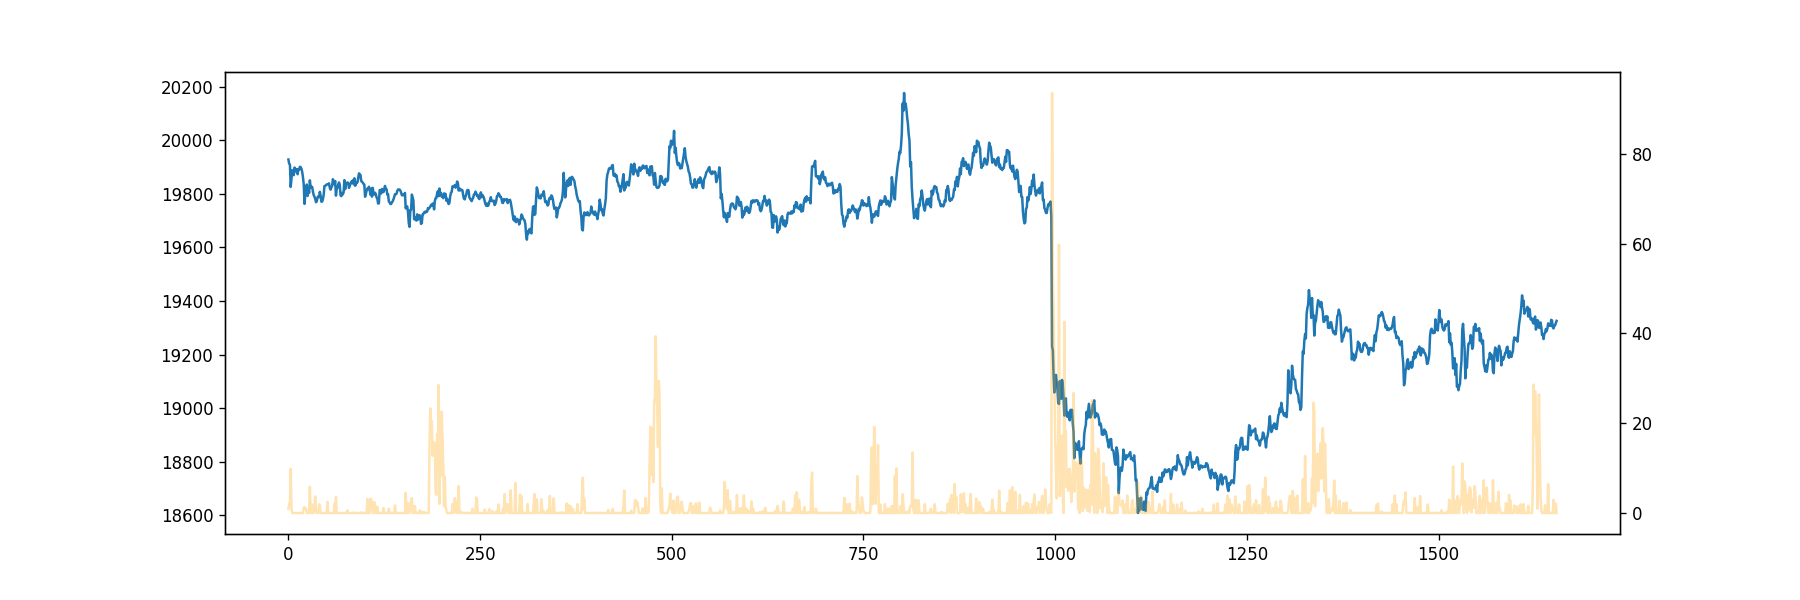

In [35]:
dataset["spread"] = dataset["lowest_ask"] - dataset["highest_bid"]

fig, ax = plt.subplots(figsize=(15,5), dpi=60)
ax2 = ax.twinx()
x_data = list(range(dataset.shape[0]))

ax.plot(x_data, dataset["highest_bid"])
ax2.plot(x_data, dataset["spread"], color="orange", alpha=0.3)


Визуально информации в спреде нет.

## Объемы

<IPython.core.display.Javascript object>


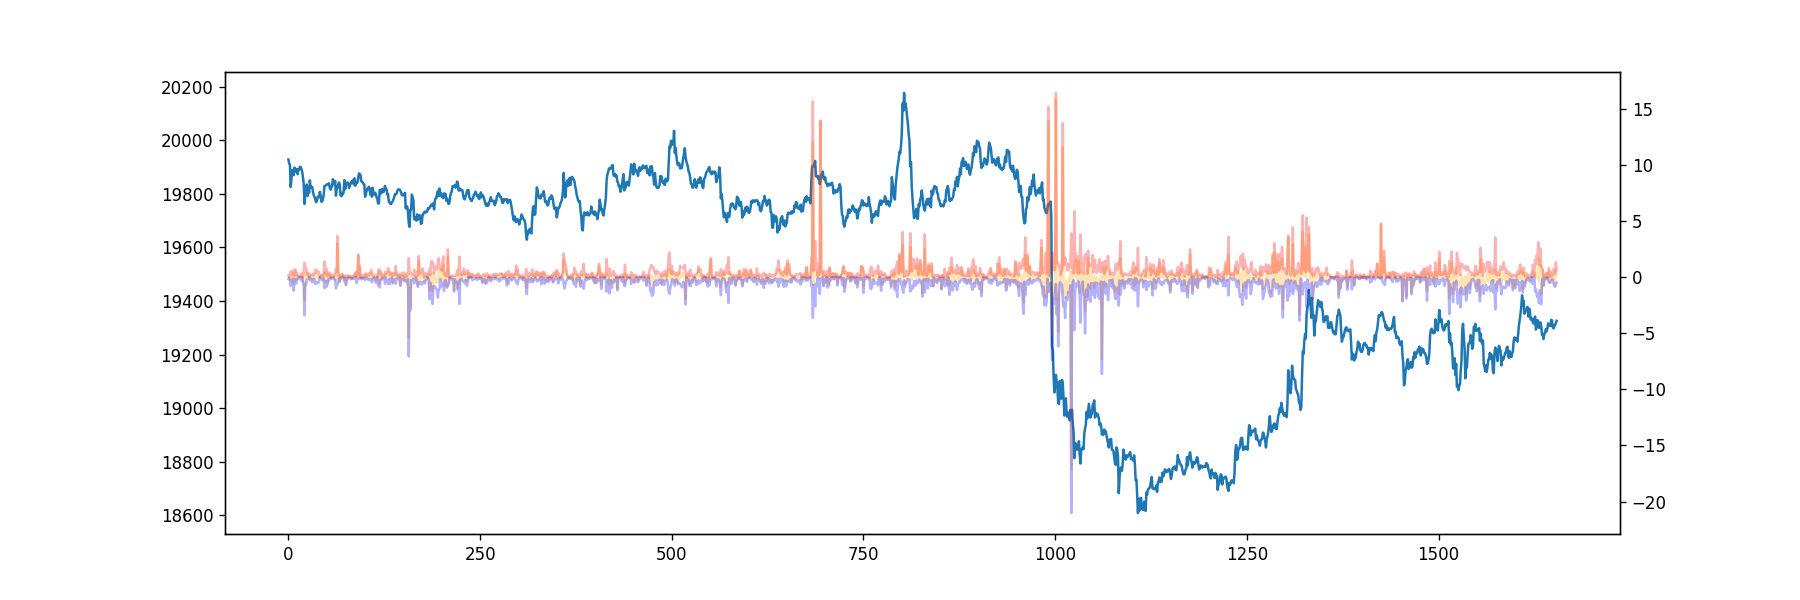

In [36]:
dataset["trade_volume_diff"] = dataset["buy_vol"] - dataset["sell_vol"]

fig, ax = plt.subplots(figsize=(15,5), dpi=60)
ax2 = ax.twinx()
x_data = list(range(dataset.shape[0]))

ax.plot(x_data, dataset["highest_bid"])


ax2.plot(x_data, dataset["trade_volume_diff"], color="orange", alpha=0.3)


ax2.plot(x_data, dataset["buy_vol"], color="red", alpha=0.3)
ax2.plot(x_data, dataset["sell_vol"] *-1, color="blue", alpha=0.3)

Торговые объемы временами показывают очевидные тренды. Но не всегда.

## Изменения стаканов

<IPython.core.display.Javascript object>


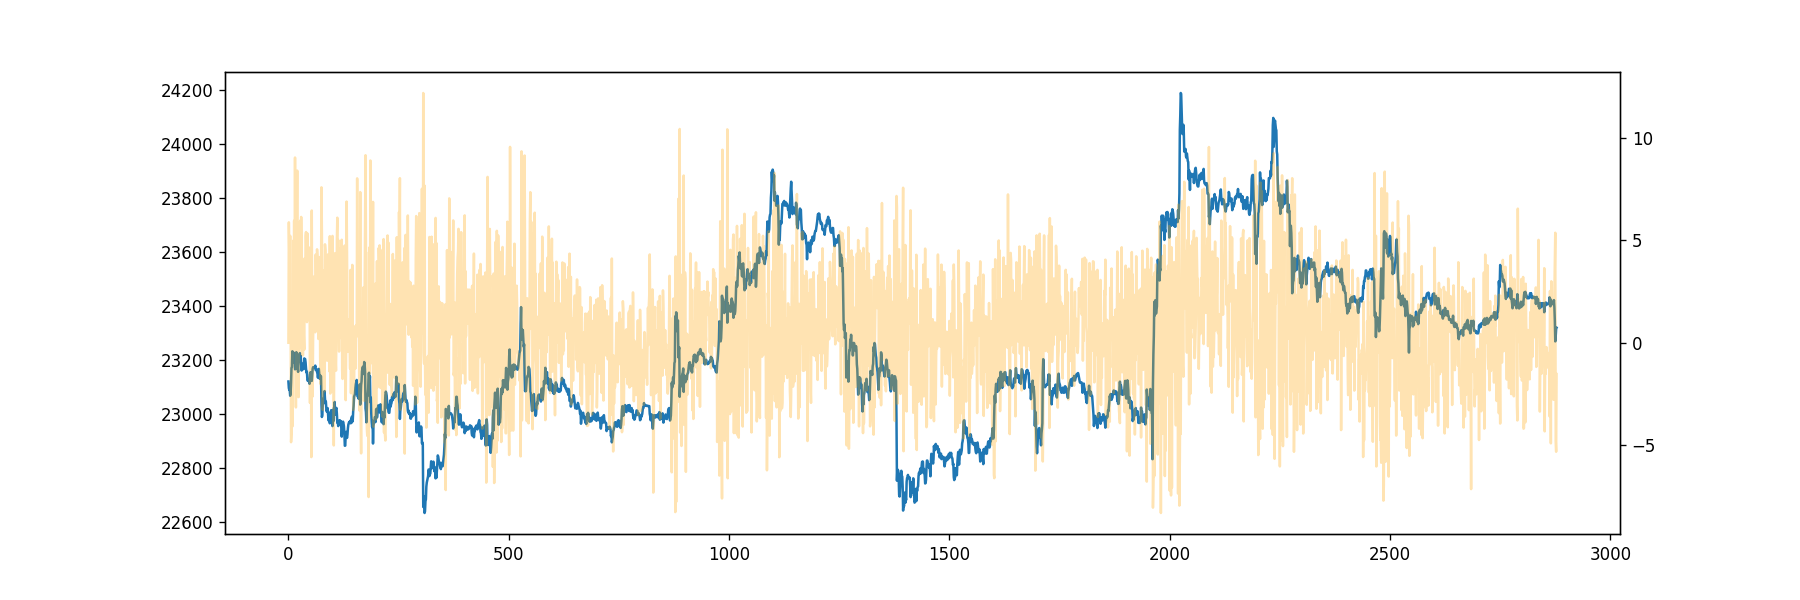

In [54]:
dataset["feature"] = dataset["asks_0.001"] - dataset["bids_0.001"]

fig, ax = plt.subplots(figsize=(15,5), dpi=60)
ax2 = ax.twinx()
x_data = list(range(dataset.shape[0]))

ax.plot(x_data, dataset["highest_bid"])


ax2.plot(x_data, dataset["feature"], color="orange", alpha=0.3)

# Исследование observation

In [19]:
core_config = {
    "action_controller":{"class": "BasicTrainController", "params":{ 
            "penalty": -2, 
            "market_fee": 0.0015,
            "wait_scale": 0, 
            "open_scale": 0, 
            "hold_scale": 0, 
            "close_scale": 100, 
            "last_points_mean": 2
        },},


    "observation_builder":{
        "class": "ObservationBuilder",
        "inputs": [
            {"class": "Input1D", "features": [{"class": "RawContextFeature", "params": {"name":"is_open"}}]},
            {"class": "Input2D", "features": [
                {"class": "RatesFeature", "params": {"step_factor":1, "scale_output": 30}},
                {"class": "MovingAverageFeature", "params": {"step_factor":1, "scale_output":30, "ma_points":3, "feature":"highest_bid"}},
                {"class": "MovingAverageFeature", "params": {"step_factor":1, "scale_output":30, "ma_points":7, "feature":"highest_bid"}},
                
                {"class": "ProfitFeature", "params": {"step_factor":1, "scale_output": 0.5, "normalization":True, "clip_output":2}},
                {"class": "TradeVolumes", "params": {"step_factor":1, "scale_output": 0.2, "clip_output":2}},
                {"class": "TradeCount", "params": {"step_factor":1, "scale_output": 0.2, "clip_output":2}},

                {"class": "OrderbookDiffFeature", "params": {"step_factor":1, "level": 0.0005, "scale_output": 0.3}}, 
                {"class": "OrderbookDiffFeature", "params": {"step_factor":1, "level": 0.001, "scale_output": 0.3}}, 
                {"class": "OrderbookDiffFeature", "params": {"step_factor":1, "level": 0.0025, "scale_output": 0.3}},
                {"class": "OrderbookDiffFeature", "params": {"step_factor":1, "level": 0.005, "scale_output": 0.3}}
            
            ]}
        ]
    }
}
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
core_constructor = Constructor()
core = core_constructor.get_core("test", core_config)

In [20]:
# Параметры точки наблюдения
observation_len = 50
step_size = 1
max_step_factor = get_max_step_factor(core_config)*3
offset = 2 * max_step_factor * observation_len + max_step_factor + 20

dp_factory_config = {
    "observation_len": observation_len,               # Количество точек наблюдения в сэмпле
    "offset": offset,                                 # Хвост исторических данных
    "future_points": 0,                               # Количество будущех точек для предсказания тренда (временное решение)
    "step_size": step_size                            # Шаг по датасет
 }

dpf = DataPointFactory(dataset=dataset, **dp_factory_config, alias='train')
dpf

In [21]:
dpf.get_max_steps()

828

In [21]:
#data_raw = distribution_analysis(dpf, core, trade_every=50, plot_x_size=3, plot_y_size=3)

## Observation

In [22]:
dp = dpf.reset()
core.reset(data_point=dp)
observation2d = core.get_observation(dp)[1]

In [18]:
for i in range(observation_len//2):
    dp, done = dpf.get_next_step()
    if done:
        print("done")
        break
        
observation2d = core.get_observation(dp)[1]


done


In [26]:
fix, ax = plt.subplots(figsize=(11,4))

idx = 0 # rates
name = core.observation_builder.inputs[1].features[idx].__str__()
print(name)
y_data = observation2d[:, idx]
x_data = range(len(y_data))
ax.plot(x_data, y_data, label=name)
"""
idx = 1 # ma_3
name = core.observation_builder.inputs[1].features[idx].__str__()
print(name)
y_data = observation2d[:, idx]
x_data = range(len(y_data))
ax.plot(x_data, y_data, label=name, color="green", alpha=0.6)

idx = 2 # ma_10
name = core.observation_builder.inputs[1].features[idx].__str__()
print(name)
y_data = observation2d[:, idx]
x_data = range(len(y_data))
ax.plot(x_data, y_data, label=name, color="green", alpha=0.3)"""


ax2 = ax.twinx()
idx = 6
name2 = core.observation_builder.inputs[1].features[idx].__str__()
print(name2)
y_data2 = observation2d[:, idx]
x_data2 = range(len(y_data))

add_bar_data(x_data2, y_data2, ax=ax, name=name2)




ax.legend()





<IPython.core.display.Javascript object>

RatesFeature-step_factor:1
OrderbookDiffFeature-step_factor:1-level:0.0005


In [61]:
dataset.columns

Index(['dt', 'lowest_ask', 'highest_bid', 'asks', 'bids', 'buy_vol',
       'sell_vol', 'total_vol', 'buy_num', 'sell_num', 'total_num',
       'asks_0.001', 'bids_0.001', 'asks_0.0025', 'bids_0.0025', 'asks_0.005',
       'bids_0.005', 'asks_0.01', 'bids_0.01', 'feature'],
      dtype='object')

In [51]:
sell_vol_norm = dp.get_values("sell_vol", step_factor=1, num=-1)
buy_vol_norm = dp.get_values("buy_vol", step_factor=1, num=-1)

In [53]:
np.concatenate([sell_vol_norm, buy_vol_norm]).mean()

0.04761317964447222